# Lecture 4: Introduction to Markov chain Monte Carlo (MCMC) Methods
In the last lecture we learned how to use Monte Carlo methods to approximate both posterior distributions and their quantities of interest. The critical assumption was that we know how to directly sample from the posterior distribution. This is not always the case. In this lecture we will learn how to sample from unknown distributions using [Markov chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methods. First, we load some useful packages.

In [1]:
# Use packages 
using Distributions  # Work with standard probability distributions
using Plots  # Create plots

## Markov chain Monte Carlo (MCMC) methods
Direct Monte Carlo sampling can be viewed as the gold standard of posterior simulation algorithms. This is because it provides draws from the posterior distribution that are independent and identically distributed (iid). Such draws can be obtained when working with known distributions, e.g. Normal, Beta, Gamma etc, however it is often not possible to do so when the posterior is of unknown form. In such cases we instead use *indirect sampling methods*. The two most common of which are:
1. Importance sampling (IS)
2. Markov chain Monte Carlo (MCMC)

Since we have time constraints, and both methods allow us to do the same thing, in this course we will focus on MCMC methods due to their wider use in economics. 

[MCMC methods](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) are a class of algorithms that allow us to sample from unknown distributions and approximate their features. As Bayesians, we often use MCMC methods to sample from posterior distributions.

The basic idea underlying MCMC is that we first specify a candidate function from which we can obtain random samples. We then use the candidate function to generate candidate draws that we use to approximate the target distribution. If all goes well then this approximation will converge in distribution to a *target distribution* (also known as the *stationary distribution*). Two popular MCMC methods to construct the Markov chain are:
1. Metropolis-Hastings (MH) algorithm
2. Gibbs sampling 

### Metropolis-Hastings (MH) algorithm
Suppose that we want to sample the $K\times 1$ parameter vector $\boldsymbol{\theta}=(\theta_{1},\dots,\theta_{K})'$, from the posterior distribution $p(\boldsymbol{\theta}|\mathbf{y})$, but can't draw directly from it. We can get around this problem by constructing a Markov chain of samples from a transition density $q(\cdot)$ (also known as the candidate distribution) that satisfies the [Markov property](https://en.wikipedia.org/wiki/Markov_property) - i.e. the current state $\boldsymbol{\theta}_d=(\theta_{d,1},\dots,\theta_{d,K})'$ only depends on the most previous state $\boldsymbol{\theta}_{d-1}=(\theta_{d-1,1},\dots,\theta_{d-1,K})'$, so that $q(\boldsymbol{\theta}_d|\boldsymbol{\theta}_{d-1},\cdots,\boldsymbol{\theta}_{1},\boldsymbol{\theta}_{0}) = q(\boldsymbol{\theta}_d|\boldsymbol{\theta}_{d-1})$. Under some conditions (see [Hastings (1970)](http://appliedmaths.sun.ac.za/~htouchette/markovcourse/1970_monte%20carlo%20sampling%20methods%20using0.pdf)), the Markov chain will converge in distribution to the true posterior distribution given a large enough set of draws $D$. Since the behavior of the Markov chain will generally depend on the initial condition, it's common to discard the first "few" draws as a *burn-in* period. 

**Metropolis–Hastings Algorithm**: Given an initial condition $\boldsymbol{\theta}_0$ (typically a guess), and a transition density $q(\cdot)$, repeat the following steps for $d=1,\dots,D$
1. **Sample** a candidate draw $\boldsymbol{\theta}_{c}\sim q(\boldsymbol{\theta}_{c}|\boldsymbol{\theta}_{d-1})$
2. **Update** $\boldsymbol{\theta}_{d}=\boldsymbol{\theta}_{c}$ with probability $\alpha=\min(\{1,\frac{p(\boldsymbol{\theta}_{c}|\mathbf{y})q(\boldsymbol{\theta}_{d-1}|\theta_{c})}{p(\boldsymbol{\theta}_{d-1}|\mathbf{y})q(\boldsymbol{\theta}_{c}|\boldsymbol{\theta}_{d-1})}\})$

    From a practical perspective, note that we accept/reject the proposal by comparing $\alpha$ with a draw of a uniform random variable over the unit interval, i.e. $u\sim U[0,1]$. If $\alpha\geq u$ then we accept the candidate draw, otherwise we reject it and remain at the previous draw.

To operationalize the MH algorithm we need to select the transition density. There are two common approaches:
1. Independence chain
2. Random walk

**Remarks**:
1. **Name**: The Metropolis-Hastings (MH) algorithm is named after the researchers in two papers: [Metropolis et al (1953)](https://aip.scitation.org/doi/abs/10.1063/1.1699114) and [Hastings (1970)](http://appliedmaths.sun.ac.za/~htouchette/markovcourse/1970_monte%20carlo%20sampling%20methods%20using0.pdf).
2. **Derivation**: In this course we will use the MH algorithm without deriving it. For those interested in learning more about where it comes from, see this [formal derivation](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm#Formal_derivation) along with the theory in [Hastings (1970)](http://appliedmaths.sun.ac.za/~htouchette/markovcourse/1970_monte%20carlo%20sampling%20methods%20using0.pdf). From a practical perspective, the important condition is that the transition density is able to generate all of the values within the support of the posterior distribution.
3. **Proportionality**: When using the MH algorithm we only need to know the target function up to a multiplicative constant. This is useful because we can work directly with the likelihood and the prior without having to compute the marginal distribution.

#### Independence chain
The simplest type of transition density allows us to draw candidates $\theta_{c}$ independent of the previous state $\theta_{d-1}$, i.e. $q(\theta_{c}|\theta_{d-1})=q(\theta_{c})$. This is referred to as the *independent Metropolis-Hastings algorithm* or *independence chain Metropolis-Hastings algorithm*. In this case the acceptance probability is 
$$\alpha=\min(\{1,\frac{p(\theta_{c}|\mathbf{y})q(\theta_{d-1})}{p(\theta_{d-1}|\mathbf{y})q(\theta_{c})}\})
$$ 

**Example**: Suppose that we want to sample obtain random samples from
$$
f(x) = \frac{1}{2}\exp(-|x|)
$$
Since the support of this function is the entire real line, we can use the standard Normal distribution $N(0,1)$ as a transition density. This is done in the following Julia code.


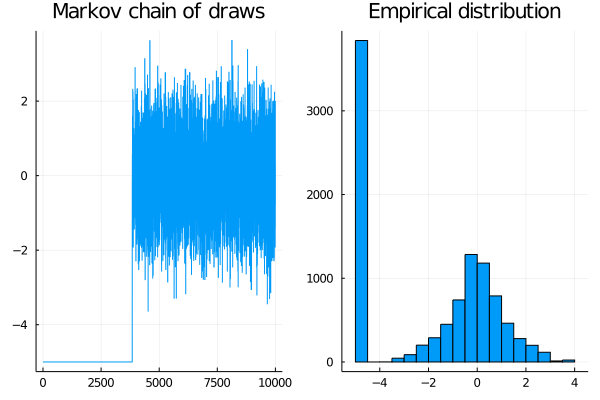

In [28]:
## Independence chain MH algorithm
## Create functions
# Target distribution
function p(x)
    exp(-abs(x))/(2);
end

# Proposal distribution
function q(x)
    pdf(Normal(0,1),x);
end

# Acceptance probability
function a(x,y)
    min(1, p(x)*q(y)/(p(y)*q(x)));
end

## Independence chain MH sampler
# Set-up
D = 10000; # number of draws in Markov chain
x = zeros(D); # storage vector
x[1] = -5; # initial condition

#Markov chain
for d in 2:D
#1. Sample candidate
    xc = rand(Normal(0,1));
#2. Update
    alp = a(xc,x[d-1]);
    u = rand(Uniform(0,1));
    if alp >= u
        x[d] = xc;
    else
        x[d] = x[d-1];
    end
end

## Summary
p1 = plot(x, title = "Markov chain of draws");
p2 = histogram(x, title = "Empirical distribution");

plot(p1,p2,layout = (1,2),legend=false)

Now suppose that a friend tells you that the target distribution is actually the pdf of a [Laplace random variable](https://en.wikipedia.org/wiki/Laplace_distribution) with location parameter $\mu=0$ and scale parameter $b=1$. We can consequently determine the accuracy of our approximation by comparing it to the true distribution.

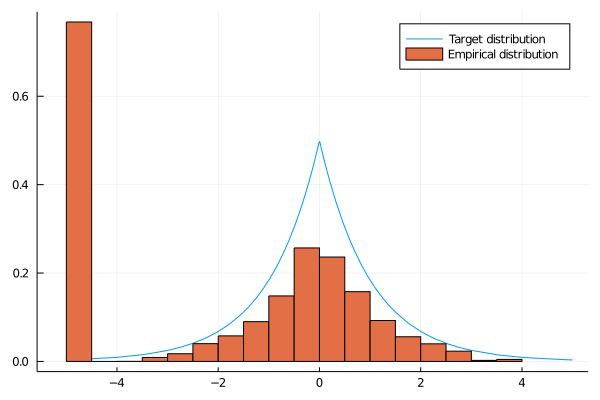

In [29]:
# Compare empirical distribution to target
X = Laplace(0,1);
plot(x -> pdf(X, x), labels = "Target distribution")
histogram!(x,normalize=:pdf, labels = "Empirical distribution")

**Remarks**:
1. **Burn-in**: When using the MH algorithm the first *few* draws are usually discarded because they will not be from the target distribution. These draws are known as *burn-in draws* and are discarded before doing any analysis. We will return to this point later on in the lecture.
2. **Good and bad proposals**: Selection of a good proposal distributions is an area of active research. If the proposal distribution is equal to the target distribution, i.e. $q(\theta)=p(\theta|\mathbf{y})$, then the acceptance probability is 1 and the proposal is always accepted. As a rule of thumb, we therefore try to choose a transition density that is as close as possible to the target distribution. 
4. **Unimodal distributions**: When the posterior distribution is unimodal, it's common to specify the transition density as a Normal distribution. Moreover, if the posterior mode is easy to compute, then we can increase the computational efficiency of the sampler by centering the proposal at the posterior mode. This strategy is used in e.g. [Chan (2015)](https://www.tandfonline.com/doi/abs/10.1080/07350015.2015.1052459) to estimate a *stochastic volatility in mean model with time-varying parameters*. You should be able to replicate this paper by the end of the course. 

#### Random walk
Following [Metropolis et al (1953)](https://aip.scitation.org/doi/abs/10.1063/1.1699114), it's common to specify a random walk transition density:
$$
\theta_c = \theta_{d-1} + Z,
$$ 
where $Z$ is a random variable. This is sometimes referred to as the *Random walk Metropolis algorithm*, however, since it's a special case of the MH algorithm we will stick with the MH terminology and refer to it as the *Random walk Metropolis-Hastings algorithm*.

If the distribution of $Z$ is symmetric, then $q(\theta_{c}|\theta_{d-1})=q(\theta_{d-1}|\theta_{c})$ and the acceptance probability becomes
$$
\alpha=\min(\{1,\frac{p(\theta_{c}|\mathbf{y})}{p(\theta_{d-1}|\mathbf{y})}\})
$$ 
In practice, it's common to specify the transition density as a Normal distribution. In this case the equation system representation is 
$$
\theta_c = \theta_{d-1} + Z, \quad Z\sim N(0,\sigma^2)
$$ 
in which $\sigma^2$ is a user specified variance that is calibrated to ensure a suitable acceptance rate. Alternatively, the probability model representation is 
$$
\theta_c \sim N(\theta_{d-1},\sigma^2)
$$

**Example**: Consider again the example in which we want to sample from the pdf of a random variable $X$ with pdf given by
$$
f(x) = \frac{1}{2}\exp(-|x|)
$$
Since the support of $X$ is the entire real line, we can sample from this pdf using a Gaussian random walk.

In [1]:
## Random walk MH algorithm
## Create functions
# Target distribution
function p(x)
    exp(-abs(x))/(2);
end

# Acceptance probability
function a(x,y)
    min(1, p(x)/p(y));
end

## Random walk MH sampler
# Set-up
D = 10000; # number of draws in Markov chain
x = zeros(D); # storage vector
x[1] = -5; # initial condition
sig = 1;   # RW standard deviation
cnt_acc = zeros(D); # count variable for acceptance ratio

#Markov chain
for d in 2:D
#1. Sample candidate
    xc = x[d-1] + sig*rand(Normal(0,1));
#2. Update
    alp = a(xc,x[d-1]); # acceptance probability
    u = rand(Uniform(0,1));
    if alp >= u
        x[d] = xc;
        cnt_acc[d] = cnt_acc[d-1] + 1;
    else
        x[d] = x[d-1];
        cnt_acc[d] = cnt_acc[d-1];
    end
end

## Summary
@show acc_rat = cnt_acc[end]/D;# acceptance ratio
# Trace plot
p1 = plot(x, title = "Trace plot", labels = "MCMC Draws");

# Compare true to MH
X = Laplace(0,1);
plot(x -> pdf(X, x), title = "Empirical and actual distribution", labels = "Target distribution")
p2 = histogram!(x,normalize=:pdf, labels = "Empirical distribution")

plot(p1,p2,layout = (1,2))


LoadError: UndefVarError: Normal not defined

**Remarks**:
1. **Jargon**: In the equation system representation, the random variable $Z$ is sometimes referred to as the *jump variable* and $\sigma$ as the *jump parameter*.  
2. **Small jump parameter**: If the random walk *jumps* are very "small" (i.e. $\sigma$ is small relative to the scale of the parameters in $\theta$), then the acceptance probability will be close to one because points that are close to each other have similar densities. As a result, the candidate draw is almost always accepted, but the resulting chain will have high autocorrelation.
3. **Large jump parameter**: If the random walk *jumps* are very large (i.e. $\sigma$ is large relative to the scale of the parameters in $\theta$), then the acceptance probability will be close to zero if the previous draw $\theta_{d-1}$ is in a high probability region. As a result, the candidate draw is almost never accepted, the chain will get stuck, and the resulting chain will have high autocorrelation.
4. **Tuning the jump parameter**: Since the objective to to get independent draws (as in direct sampling), it's common practice to tune the variance parameter to get an acceptance ratio of 20-45%. This tuning is usually done by trial and error, however some [adaptive MCMC algorithms](https://link.springer.com/article/10.1007/s11222-008-9110-y) have been developed. The range stems from Gelman, Roberts and Wilks ([1994](http://www.stat.columbia.edu/~gelman/research/published/theory7.pdf),[1996](http://stat.columbia.edu/~gelman/research/published/baystat5.pdf)) who find optimal acceptance ratios of 45% for univariate problems and 23% in the limit.

### Gibbs sampling
Suppose that there exits a partition $\boldsymbol{\theta}=\{\boldsymbol{\theta}_{1},\dots,\boldsymbol{\theta}_{B}\}$, in which $\boldsymbol{\theta}_{i}$, $i=1,\dots,B$ may be scalars or vectors, and that we can sample from each component of the *full conditional distributions*
1. $p(\theta_{1}|\mathbf{y},\theta_{2},\dots,\theta_{B})$
2. ...
3. $p(\theta_{B}|\mathbf{y},\theta_{1},\dots,\theta_{B-1})$

Then, we can use these conditional distributions as the transition density in the MH algorithm. In this case the update probability equals one, so each candidate draw is always accepted. This idea is referred to as *Gibbs sampling* as is summarized in the following algorithm.

**Gibbs Sampling**: Let $\boldsymbol{\theta}_{d,b}$ denote the dth draw of the bth block of a partition $\boldsymbol{\theta}=\{\boldsymbol{\theta}_{1},\dots,\boldsymbol{\theta}_{B}\}$. Then, given a set of initial conditions $\boldsymbol{\theta}_{0,1},\dots,\boldsymbol{\theta}_{0,B}$ (typically a guess), the Gibbs sampling algorithm works as follows
1. **Sample** a draw from the full set of conditional distributions: 
    1. $\boldsymbol{\theta}_{1,1}\sim p(\boldsymbol{\theta}_{1,1}|\mathbf{y},\boldsymbol{\theta}_{0,2},\dots,\boldsymbol{\theta}_{0,B})$
    2. $\boldsymbol{\theta}_{1,2}\sim p(\boldsymbol{\theta}_{1,2}|\mathbf{y},\boldsymbol{\theta}_{1,1},\boldsymbol{\theta}_{0,3},\dots,\boldsymbol{\theta}_{0,B})$
    3. ...
    4. $\boldsymbol{\theta}_{1,B}\sim p(\theta_{1,B}|\mathbf{y},\theta_{1,1},\dots,\theta_{0,B-1})$
2. **Repeat** for $d=2,\dots,D$, i.e. 
    1. $\boldsymbol{\theta}_{d,1}\sim p(\theta_{d,1}|\mathbf{y},\theta_{d-1,2},\dots,\theta_{d-1,B})$
    2. $\boldsymbol{\theta}_{d,2}\sim p(\boldsymbol{\theta}_{d,2}|\mathbf{y},\boldsymbol{\theta}_{d,1},\boldsymbol{\theta}_{d-1,3},\dots,\boldsymbol{\theta}_{0,B})$
    3. ...
    4. $\boldsymbol{\theta}_{d,B}\sim p(\theta_{d,B}|\mathbf{y},\theta_{d,1},\dots,\theta_{d-1,B-1})$

Following these steps will provide us with a set of $D$ draws $\theta_1,\dots,\theta_D$. Given a large enough set of draws $D$, then the Markov chain will converge in distribution to the true posterior distribution.

**Remarks**:
1. Gibbs sampling is named after the physicist Josiah Gibbs, however the foundations come from [Geman and Geman (1984)](https://ieeexplore.ieee.org/document/4767596)
2. The choice of simulation size $D$ will effect the accuracy of both the empirical distribution to the posterior distribution and the associated Monte Carlo integrals to the true quantities of interest

# Worked Example: Random Walk with Drift Model
The random walk model used in the previous lecture can be extended to have a non-zero mean by adding a constant term, i.e.
$$
Y_t = \mu + Y_{t-1} + e_t, \quad e_t\sim N(0,\sigma^2)
$$
in which $\mu$ is an unknown real-valued constant. This is known as the random walk with drift model. 

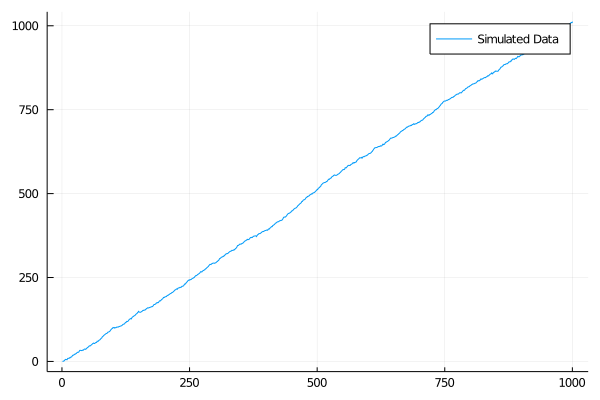

In [5]:
## Simulate Data from random walk with drift model
true_mu = 1; # true mean
true_sig2 = 1; # true variance
T = 1001; # no. of dates
y0 = 0;   # initial condition
y = zeros(T); # storage vector

y[1] = y0;
for t = 2:T
    y[t] = true_mu + y[t-1] + rand(Normal(0,sqrt(true_sig2)));
end

x = collect(1:1:T);
plot(x,y, label="Simulated Data")

We can estimate this model using Bayesian methods. Since the mean of the above distribution is known, we can take it to the left and side and instead work with the *first-difference* of the data $\Delta Y_t=Y_t-Y_{t-1}$ to estimate the model
$$
\Delta Y_t\sim N(\mu,\sigma^2)
$$

This shows that estimating the random walk with drift model is the same as estimating the parameters of the normal distribution with unknown mean and unknown variance. 

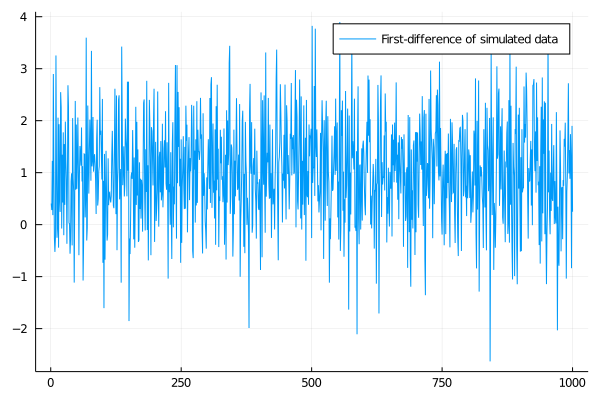

In [6]:
# Plot data in first differences
Dy = y[2:end] - y[1:end-1];
T = length(Dy);
x = collect(1:1:T);
plot(x,Dy, label="First-difference of simulated data")

**Likelihood**: Let $\theta = (\mu,\sigma^2)'$ denote the vector of unknown parameters. The likelihood of this model is given by
$$
\begin{align}
p(\mathbf{Y}|\theta) &= \prod_{t=1}^{T}p(\Delta Y_t|\theta)\\
&= \prod_{t=1}^{T}(2\pi\sigma^2)^{-\frac{1}{2}}\exp(-\frac{1}{2\sigma^2}(\Delta Y_t-\mu)^2)\\
&= (2\pi\sigma^2)^{-\frac{T}{2}}\exp(-\frac{1}{2\sigma^2}\sum_{t=1}^{T}(\Delta Y_t-\mu)^2)
\end{align}
$$

**Priors**:
When setting the priors we need to make an assumption about the dependence of the unknown parameters. Here we will assume that they are independent, so that $p(\mu,\sigma^2)=p(\mu)p(\sigma^2)$ and set the following independent prior distributions:
1. Since $\mu$ can be any real number, we will assume that $\mu\sim N(m_0,v^2_0)$ 
2. Since $\sigma^2>0$, we will assume that $\sigma^2\sim IG(\nu_0,S_0)$ 

**Posterior**:
To get the posterior, we combine the prior and likelihood
$$
\begin{align}
p(\theta|\mathbf{Y}) &\propto p(\mathbf{Y}|\theta)p(\theta)\\
                     &\propto p(\mathbf{Y}|\theta)p(\mu)p(\sigma^2)\\
                     &\propto (\sigma^2)^{-(\frac{T}{2}+\nu_0+1)}\exp(-\frac{1}{2\sigma^2}(S_0 + \sum_{t=1}^{T}(\Delta Y_t-\mu)^2) -\frac{1}{2 v^2}(\mu-m_0)^2)\\
\end{align}
$$
The final expression is an unknown distribution meaning that we can not apply direct Monte Carlo sampling methods. The trick to estimating it is noticing that the posterior distribution looks like it is Normal in $\mu$ and inverse-Gamma in $\sigma^2$. We can therefore try a two block Gibbs Sampler with the full conditional distributions
1. $p(\mu|\mathbf{y},\sigma^2)$
2. $p(\sigma^2|\mathbf{y},\mu)$

First block: let $\bar{Y} = \frac{1}{T}\sum_{t=1}^{T}\Delta Y_t$, then
$$
\begin{align}
p(\mu|\mathbf{y},\sigma^2)&\propto p(\mathbf{Y}|\theta)p(\mu)\\
                          &\propto\exp(-\frac{1}{2\sigma^2}(\sum_{t=1}^{T}(\Delta Y_t-\mu)^2) -\frac{1}{2 v^2}(\mu-m_0)^2)\\
                          &=\exp(-\frac{1}{2}(\frac{1}{\sigma^2}((T\bar{Y})^2-2 T\bar{Y}\mu+T\mu^2)) -\frac{1}{v^2}(\mu^2-2\mu m_0 + m_0^2))\\
                          &\propto\exp(-\frac{1}{2}(\frac{1}{\sigma^2}((-2 T\bar{Y}\mu+T\mu^2)) -\frac{1}{v^2}(\mu^2-2\mu m_0))\\
                          &=\exp(-\frac{1}{2}((\frac{T}{\sigma^2} + \frac{1}{v^2})\mu^2 -2\mu(\frac{T\bar{Y}}{\sigma^2} + \frac{m_0}{v^2})))                   
\end{align}
$$
If we stare at this expression long enough, then we (hopefully) will see that it is the kernel of a Normal distribution. To determine the mean and variance, note that if $\mu\sim N(\hat{\mu},D_\mu)$ then
$$
p(\mu|\mathbf{y},\sigma^2) \propto \exp(-\frac{1}{2 D_\mu}(\mu^2-2\mu\hat{\mu}))
$$
Thus, $\hat{\mu}=D_\mu(\frac{T\bar{Y}}{\sigma^2} + \frac{m_0}{v^2})$ and $D_{\mu}=(\frac{T}{\sigma^2} + \frac{1}{v^2})^{-1}$.

Second block: 
$$
\begin{align}
p(\sigma^2|\mathbf{Y},\mu) &\propto p(\mathbf{Y}|\theta) p(\sigma^2)\\
                       &= (\sigma^2)^{-(\frac{T}{2}+\nu_0+1)}\exp(-\frac{1}{\sigma^2}(S_0+\frac{1}{2}\sum_{t=1}^{T}(\Delta Y_t-\mu)^2)
\end{align}
$$
Thus, the conditional posterior for is an inverse-Gamma distribution with scale parameter $\nu = \frac{T}{2}+\nu_0+1$ and shape parameter $S = S_0+\frac{1}{2}\sum_{t=1}^{T}(\Delta Y_t-\mu)^2$. 

true_mu = 1
post_mu = 1.011171930914433
true_sig2 = 1
post_sig2 = 0.9761222078599523


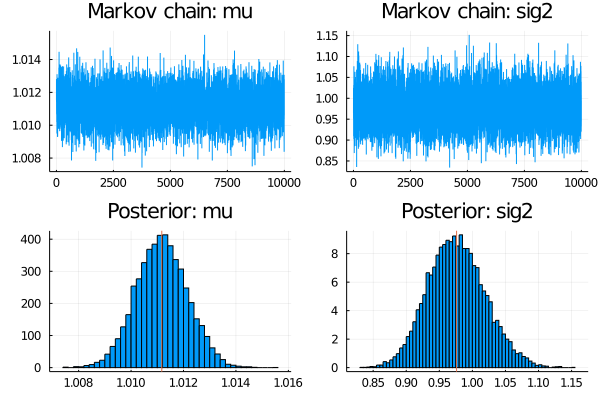

In [26]:
## Gibbs Sampler for the random walk with drift model
## Priors
# Prior for mu
pri_m = 0;
pri_v2 = 10;
pri_mu = Normal(pri_m,sqrt(pri_v2));

# Prior for sig2
pri_nu = 3;
pri_S = 1*(pri_nu-1); # sets E(pri_sig2) = 1
pri_sig2 = InverseGamma(pri_S,pri_S);

## Gibbs Sampler
# Controls
nburn = 1000;
ndraws = nburn + 10000;

# Storage
s_mu = zeros(ndraws-nburn,1);
s_sig2 = zeros(ndraws-nburn,1);

# Deterministic terms
ybar = mean(Dy);
post_nu = pri_nu + T/2;

# Initial conditions
let MC_mu = mean(Dy), MC_sig2 = var(Dy)
# Markov chain
    for loop in 1:ndraws
    # Draw mu
        post_v2 = 1/(T/MC_sig2 + 1/pri_v2);
        post_m = post_v2*(T*ybar/MC_sig2 + pri_m/pri_v2);
        MC_mu = rand(Normal(post_m,post_v2));

    # Draw sig2
        post_S = pri_S +0.5*sum((DY.-MC_mu).^2);
        MC_sig2 = rand(InverseGamma(post_nu,post_S));

    # Store
        if loop > nburn
            count = loop - nburn;
            s_mu[count] = MC_mu;
            s_sig2[count] = MC_sig2;
        end
    end
end
## Summarize results
# Trace plots
x = collect(1:(ndraws-nburn))
p1 = plot(x,s_mu, title = "Markov chain: mu", label="Draws");
p2 = plot(x,s_sig2, title = "Markov chain: sig2", label="Draws");

# Compute posterior mean using Monte Carlo Integration
    post_mu = mean(s_mu);
    post_sig2 = mean(s_sig2);

    @show true_mu
    @show post_mu
    @show true_sig2
    @show post_sig2

# Plot posterior distribution for mu
x = collect(0:0.1:5);
histogram(x,s_mu, normalize=:pdf, title = "Posterior: mu", label="Empirical distribution")
p3 = plot!([post_mu], seriestype="vline", label="MC mean")

# Plot posterior distribution for sig2
x = collect(0:0.1:5);
histogram(x,s_sig2, normalize=:pdf, title = "Posterior: sig2", label="Empirical distribution")
p4 = plot!([post_sig2], seriestype="vline", label="MC mean")

plot(p1,p2,p3,p4,layout = (2,2),legend = false)


# Diagnostics
MCMC diagnostics are important as we need to check:
1. whether we have converged to the target distribution
2. whether the draws are sufficiently independent to ensure that the Monte Carlo integrals will converge to the target object of interest
3. whether the number of draws is sufficiently large to ensure that the Monte Carlo integrals will converge to the target object of interest
The first problem can usually be addressed using *Geweke's convergence diagnostic* and the remaining two via *trace plots* and related statistics. We will consider each in turn. 

## Geweke's convergence diagnostic
[Geweke (1992)](https://pdfs.semanticscholar.org/2e86/50b01dd557ffb15113c795536ea7c6ab1088.pdf) uses methods from spectral analysis to evaluate numerical accuracy formally and construct diagnostics for convergence of posterior moments. 

His simple idea for convergence is to compare the Monte Carlo estimates of a given quantities of interest using percentiles of the MCMC draws. That is, partition the set of draws into three subsets $\theta_{1:D_A}, \theta_{D_{A+1}:D_{B-1}},\theta_{D_B:D}$ and then compare the distributions of the first and last set of draws using a two-sample t-test of the mean with unequal variance, i.e.
$$
T = \frac{\bar{\theta_A}-\bar{\theta_B}}{\sqrt{\frac{S(0)_A}{n_A} + \frac{S(0)_B}{n_B}}}
$$
in which $\bar{\theta_i}$, $n_i$ and $S(0)_i$ $i\in\{A,B\}$ respectively denote the sample mean, size and consistent spectral density estimates of the sets $\{\theta_j, j=1,\dots,D_A\}$ and $\{\theta_j, j=D_B,\dots,D\}$. If the ratios $\frac{n_A}{D}$ and $\frac{n_B}{D}$ are fixed and $\frac{n_A+n_B}{D}<1$, then $T\underset{\to}{d} N(0,1)$ as $D\to\infty$ ($\underset{\to}{d}$ denotes convergence in distribution). We can therefore assess convergence by comparing the *convergence diagnostic* T (known as *Geweke's convergence diagnostic*) with critical values from the standard normal distribution. 

**Remarks**:
1. In his paper, [Geweke (1992)](https://pdfs.semanticscholar.org/2e86/50b01dd557ffb15113c795536ea7c6ab1088.pdf) uses $D_A=0.1 D$ and $D_B=0.5 D$ noting that these choices meet the theoretical assumptions stated above while attempting to provide diagnostic power against the possibility that the chain has not fully converged early on. However, there is no theoretically best way of choosing the same sizes.
2. Geweke’s diagnostic can be used to determine the burn‐in period, i.e., use the part of the chain that passes the diagnostic
3. In some models it's possible that Geweke's convergence diagnostic will indicate convergence when it shouldn't. Common examples are when
    1. the posterior is multi-modal - in which case we might get stuck in a local region - solve by trying different initial conditions
    2. the sampler is degenerate (meaning it doesn't update) - in which case we might change the initial conditions to get closer to a high probability region - solve by examining the trace plots


## Trace plots
To determine the total number of draws and independence of the Markov chain we generally start by looking at *trace plots*, which is plot plot of the Markov chain for given parameters. Two factors should be noted
1. The initial condition
2. Autocorrelation

### Initial conditions
Since we guess the initial condition of the Markov chain, it's highly likely that it will not be in a high density region of the parameter space. In some cases, our guess may be so poor that we get stuck in a low density region of the parameter space. When the chain is slow to converge, the distribution of the first *few* draws are likely to be far away from the target distribution (because we over sample them). This is illustrated below.

<img src="MCMC_burn_prob.png " alt="drawing" width="500"/>

Source: [Statlect](https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics)

Notice that the first part of the chain (until around $d=1,500$) has a very different distribution to the rest. As a result, it's common to discard these draws, known as a *burn-in*. This is illustrated below. 

<img src="MCMC_burn_sol.png " alt="drawing" width="500"/>

Source: [Statlect](https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics)

**Remarks**:
1. In theory, the chain will eventually converge, but in practice there is no way of knowing how long this will take. It's therefore useful to restart the analysis from different initial conditions to ensure convergence occurs. This is known as conducting *multiple chains* or *multiple runs*.

### Autocorrelation 
Recall that direct Monte Carlo sampling is the gold standard of posterior simulators because it provides us with a set of independent draws. By construction, the MCMC draws will be autocorrelated to some degree. We can eyeball the degree of autocorrelation using trace plots. If they look like white noise, then we are confident that there is low autocorrelation. In contrast, if they have an observable pattern then there is high autocorrelation. This is illustrated below.

<img src="MCMC_auto.png " alt="drawing" width="500"/>

Source: [Statlect](https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics)

Alternatively, we can directly compute the autocorrelation function (ACF) of a given chain.

<img src="MCMC_ACF.png " alt="drawing" width="500"/>

Source: [Statlect](https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics)

The ACF of Chain 1 shows some autocorrelation in the initial sample, but then goes to zero quickly. In contrast, the ACF of Chain 2 shows a large amount of autocorrelation which slowly decays. 

#### Thinning the chain & Effective Sample Size (ESS)
Since we want independent draws, when autocorrelation is high, it's common to remove some draws, known as *thinning the chain*. To do this, we look for a number $n$ such that, for any $d$, $X_{d}$ and $X_{d+n}$ is approximately independent.  We then use this thinned chain of draws to compute Monte Carlo integrals. The dimension of this sub-sample, is sometimes referred to as the *effective sample size (ESS)*. Assuming that the sample size $D$ is a multiple of $n$, then
$$
ESS = \frac{D}{n}
$$
Notice that the ESS will increase when we either increase the simulation size or decrease the amount of autocorrelation (smaller $n$). Also note that if (by a miracle) the MCMC chain produced independent draws, then $n=1$, $ESS=D$ and the sample will have the same properties as a direct Monte Carlo sample. As the degree of autocorrelation increases, $n$ will also increase and the ESS will decrease, implying that we may need to increase the simulation size $D$ to improve the accuracy of our estimates. 

#### Determining the sample size with the Inefficiency Factor (IF)
The inefficiency factor (IF) is defined as
$$
IF = \sum_{i=-\infty}^{\infty}\rho_i = 1 + 2\sum_{i=1}^{\infty}\rho_i
$$
where $\rho_i$ is the lag-i autocorrelation function of the Markov chain.

The IF value tells us the multiple of the number of draws we need to have the same information content as an independent sample obtain from e.g. direct Monte Carlo sampling. 

If the draws are independent then the correlation between draws is 0 and the inefficiency factor is 1 and the Markov chain sample contains the same information as a direct Monte Carlo sample. More generally, in order to get the same accuracy as a sample of $R$ independent draws, the MCMC scheme needs to be run for $R\times IF$ iterations.

**Remarks**:
1. In practice, using the IF is computed using the sample autocorrelation in which the lag length is selected based on an auto-correlation tapering off to zero. 
2. As a rule of thumb, people tend to accept chains that produce IFs that are less than 20 as being sufficient for analysis. 


# Conclusion
In practice, we often derive posterior distributions that are an unknown distribution for which we can't directly sample from. In this lecture we showed how to overcome these problems using [Markov chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methods. From a practical perspective, we can never be 100% sure that the Markov chain has no problems. The best we can do is analyze the chain using the diagnostics. 

MCMC is just one type of *indirect sampling methods*. Another method that is currently gaining in popularity is called *importance sampling (IS)*. A key reason for them gaining in popularity is that they can be used to estimate models with multi-modal posterior distributions. Such cases often arise in [Dynamic Stochastic General Equilibrium (DSGE) modeling](https://en.wikipedia.org/wiki/Dynamic_stochastic_general_equilibrium). Since we have time constraints, and most economic models that are used in economics and finance don't have this problem, in this course we will focus on MCMC methods. Some suggested reading for those interested in learning more about importance sampling methods:
1. For the basics of importance sampling see Chapter 11.3 of [Bayesian Econometric Methods (Econometric Exercises)](https://www.amazon.com/Bayesian-Econometric-Methods-Exercises/dp/0521671736)
2. Drew Creal provides a [nice survey paper](https://www.tandfonline.com/doi/abs/10.1080/07474938.2011.607333) on *sequential importance sampling* methods for economics and finance
3. [Sequential Monte Carlo Sampling for DSGE Models](https://onlinelibrary.wiley.com/doi/full/10.1002/jae.2397?casa_token=2T3YqC7Y01gAAAAA%3APE7FyKVT60I15mD76NaTYAsre-VDsXHGN8jbW4NmKvbLdewaV9muBnX0HpnHrbXDaCRgsY9Ez-yRLJs) by Edward Herbst and Frank Schorfheide

## Homework Problems
1. Exercises 12.1, 12.2, 12.3 and 12.8 of [Bayesian Econometric Methods (Econometric Exercises)](https://www.amazon.com/Bayesian-Econometric-Methods-Exercises/dp/0521671736)


<!--- HTML tags for comments
### Numerical standard error
Since MCMC methods produce correlated draws a different central limit theorem must be used relative to the case of Monte Carlo sampling. It turns out that a central limit theorem exists (Geweke, 1992), however the variance of the asymptotic distribution has a complicated form of which there is no consensus of how to estimate it. Following Geweke (1992), people (e.g. Koop (2007)) tend to advocate the use of
$$
\sigma^{2}_{\text{MCMC}} = \frac{S(0)}{D}
$$ 
in which $S(0)$ is the spectral density of the sequence of MCMC draws $\theta_{1},\dots,\theta_{D}$ evaluated at zero. The NSE is given by 
$$
\text{NSE}_{\text{MCMC}} = \sqrt{\frac{\sigma^2_{\text{MCMC}}}{D}}
$$ 
-->

<!--- HTML tags for comments
If all of the draws $\theta_{1},\dots,\theta_{R}$ from the posterior distribution $p(\theta|\mathbf{y})$ used in our Monte Carlo integration method are iid, and have a finite variance, then we can invoke the [Lindeberg–Lévy central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem#Lindeberg_CLT) to see that as $R\to\infty$
$$
\sqrt{R}(\hat{f}(\theta) - \theta) \to N(0,\sigma^2),
$$
in which $\sigma^2=\text{var}(\theta|\mathbf{y})$ is the standard error. We can estimate this standard error using Monte Carlo integration
$$
\hat{\sigma}^2 = \frac{1}{R}\sum_{r=1}^{R}(\theta_{r} - \hat{\theta})^2
$$
and measure the accuracy of the estimated posterior mean using the numerical standard error
$$
    NSE = \frac{\hat{\sigma}}{\sqrt{R}}
$$
In the Julia code below, we use Monte Carlo integration to approximate the mean and variance of the standard Normal distribution. Notice that the approximation gets better (and the NSE for the posterior mean gets smaller) as the simulation size increases.
We often use the inverse-Gamma (IG) distribution as a prior for random variables that are non-negative. This is because the support of the IG distribution is $(0,\infty)$. We can sample from it in Julia using the function *InverseGamma* from the [Distributions package](https://juliastats.org/Distributions.jl/v0.14/univariate.html). In this example, we will use Monte Carlo sampling to get a feel for the shape this distribution. 
-->
